# **1) Import Libraries** 
  

* Import tensorflow 
* Check for the availablity of a GPU

In [1]:
import tensorflow as tf
print("Version: ",tf.__version__)
print("GPU available: ", tf.config.list_physical_devices('GPU'))

Version:  2.3.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]




*   Import the desired transfer learning base model i.e. vgg16, vgg19, resnet
*   Import other libraries like numpy, matplotlib, os, datetime, random 



In [2]:
import os
import datetime

import random
import glob
import shutil

import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

# **2) Datetime Module Configuration**

In [28]:
def date_time(x):
  if x==1:
    return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())

# **3) Path Configuration for Train, Test and Validation Data**

In [3]:
train_path = "/content/drive/My Drive/Dataset/PETIMAGE/Train"
valid_path = "/content/drive/My Drive/Dataset/PETIMAGE/Validation"
test_path = "/content/drive/My Drive/Dataset/PETIMAGE/Test"

# **4) Data Preprocessing Using ImageDataGenerator**  


*   Reshaping all the images to (224,224)
*   The color mode here is RGB and the batch sizes for training and validation data is 10.



In [4]:
TARGET = (224,224)

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)                                    

train_generator = train_datagen.flow_from_directory(directory = train_path,
                                                   target_size = TARGET,
                                                   color_mode = 'rgb',
                                                   classes = ['Cat', 'Dog'],
                                                   batch_size = 10,
                                                   shuffle = True,
                                                   seed = 42) 
valid_generator = valid_datagen.flow_from_directory(directory = valid_path,
                                                  target_size = TARGET,
                                                  color_mode = 'rgb',
                                                  classes = ['Cat', 'Dog'],
                                                  batch_size = 10,
                                                   shuffle = True,
                                                   seed = 42)
test_generator = test_datagen.flow_from_directory(directory = test_path,
                                                 target_size = TARGET,
                                                 color_mode = 'rgb',
                                                 classes = ['Cat', 'Dog'],
                                                 batch_size = 1,
                                                 shuffle = False,
                                                 seed = 42)

Found 210 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


Calculating number of steps per epoch for train and validation generators.

In [5]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

Using assert keyword to make sure that we have the right number of images in the dataset and also the dataset has equal number of classes.

In [6]:
assert train_generator.n == 210
assert valid_generator.n == 120
assert test_generator.n == 40
assert train_generator.num_classes == valid_generator.num_classes == test_generator.num_classes

Using the next fuction to access a batch from the train generator and store the image as an array of pixels in image and the respective label in label variable.

In [7]:
image, label = next(train_generator)

# **5) Data Visualisation**  
Creating a custom function called plot_image to plot a batch of images from the respective generator alongwith the corresponding labels.

In [23]:
def plot_image(img_array, labels):
    fig, axes = plt.subplots(2, 5, figsize=(20,10))
    axes = axes.flatten()
    classes = ['Cat','Dog']
    for img, ax, label in zip(image, axes, labels):
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("{}".format(classes[np.argmax(label)]), fontsize=17)
     
    plt.tight_layout()
    plt.show()

Calling the plot_image function for a batch of images from the train_generator.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

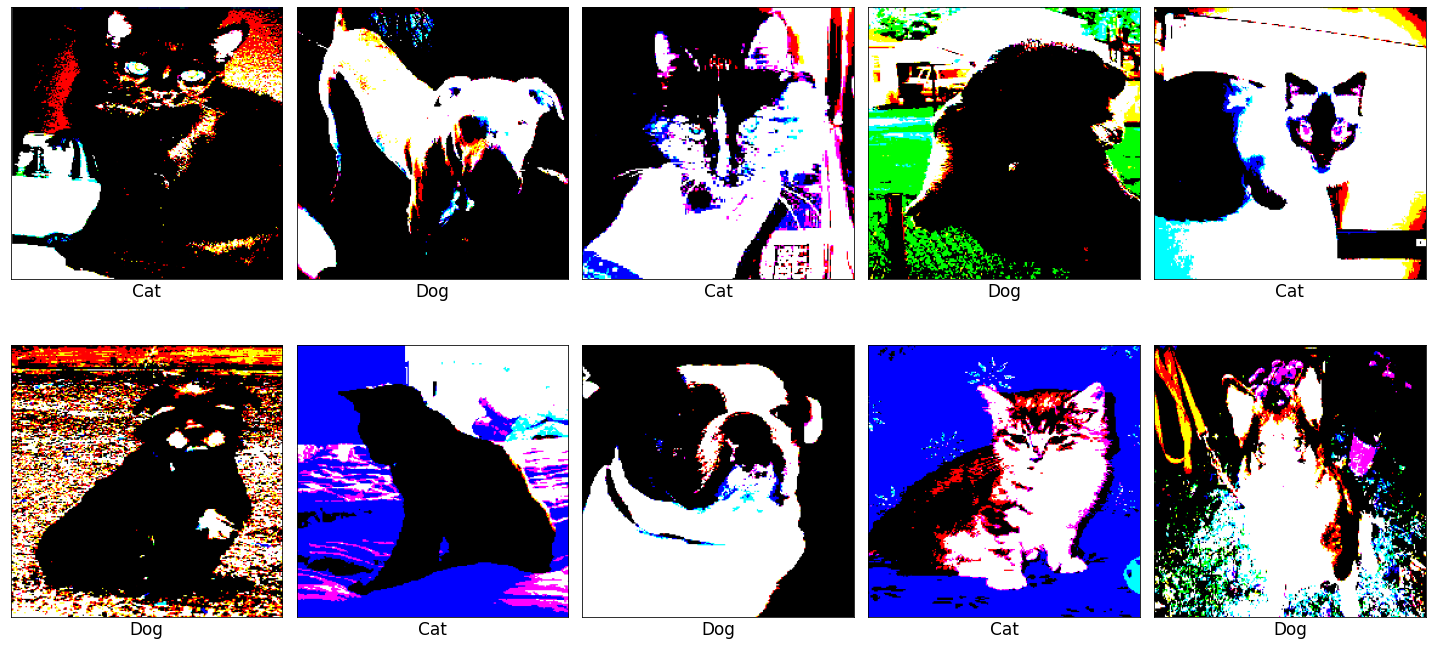

In [24]:
plot_image(image, label)

# **6) Transfer Learning**
Downloading the VGG16 model using the Keras API.

In [16]:
vgg16_model = tf.keras.applications.vgg16.VGG16()
vgg16_model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________



*   Creating a Keras Sequential model and appending the layers of vgg16 in it.
*   Freezing the layers of VGG16 so that while training the entire model these pre-trained layers are not trained again.
*  Leveraging the training of VGG16 model for our dataset.





In [17]:
model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

model.add(Dense(2, activation='softmax'))  
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       2

# **7) Compile the Model**
*   The optimizer that is being used here is Adam with a tuned learning rate of 1e-4.
*   The loss is adjusted using categorical crossentropy and metrics for the model is accuracy.



In [21]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# **8) Train the Model**
*   The model is trained using the fit_generator function
*   Training data and validation data are passed simultaneously to calculate accuracy and loss for both.



In [22]:
history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = STEP_SIZE_TRAIN,
                              validation_data = valid_generator, 
                              validation_steps = STEP_SIZE_VALID,
                              epochs=10)

Epoch 1/10
21/21 [==============================] - 2s 95ms/step - loss: 0.6288 - accuracy: 0.7381 - val_loss: 0.3481 - val_accuracy: 0.8167
Epoch 2/10
21/21 [==============================] - 2s 85ms/step - loss: 0.1915 - accuracy: 0.9429 - val_loss: 0.1907 - val_accuracy: 0.9250
Epoch 3/10
21/21 [==============================] - 2s 85ms/step - loss: 0.0961 - accuracy: 0.9762 - val_loss: 0.1453 - val_accuracy: 0.9500
Epoch 4/10
21/21 [==============================] - 2s 87ms/step - loss: 0.0592 - accuracy: 0.9905 - val_loss: 0.1181 - val_accuracy: 0.9583
Epoch 5/10
21/21 [==============================] - 2s 84ms/step - loss: 0.0412 - accuracy: 0.9952 - val_loss: 0.1040 - val_accuracy: 0.9667
Epoch 6/10
21/21 [==============================] - 2s 87ms/step - loss: 0.0311 - accuracy: 0.9952 - val_loss: 0.0953 - val_accuracy: 0.9667
Epoch 7/10
21/21 [==============================] - 2s 85ms/step - loss: 0.0249 - accuracy: 0.9952 - val_loss: 0.0890 - val_accuracy: 0.9667
Epoch 8/10
21

# **9) Performance Plot**
A function called performance_plot is created to visualize the accuracy and loss for training and validation data simultaneously. 

In [32]:
def performance_plot(history = None):
  legends = ['training', 'validation']
  plt.figure(figsize=(20,5))

  y1 = history.history['accuracy']
  y2 = history.history['val_accuracy']
  
  plt.subplot(121)
  plt.plot(y1)
  plt.plot(y2)

  plt.title('Model Accuracy\n'+date_time(1), fontsize=18)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Accuracy', fontsize=15)
  plt.legend(legends, loc='upper left')
  plt.grid()

  y1 = history.history['loss']
  y2 = history.history['val_loss']

  plt.subplot(122)
  plt.plot(y1)
  plt.plot(y2)

  plt.title('Model Loss\n'+date_time(1), fontsize=18)
  plt.xlabel('Epochs', fontsize=15)
  plt.ylabel('Loss', fontsize=15)
  plt.legend(legends, loc='upper left')
  plt.grid()

  plt.show()

Calling performance_plot using the history variable used for training our model.

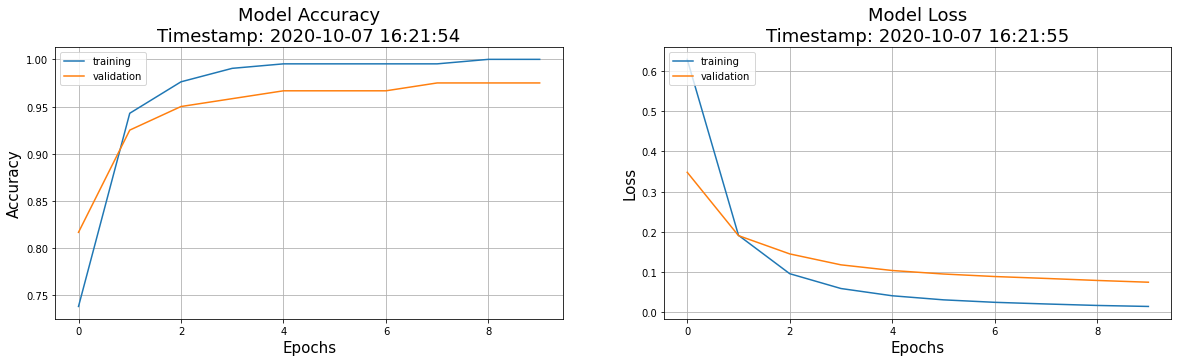

In [33]:
performance_plot(history=history)